<h1>SEGMENTATION RFM</h1> (Récence - Fréquence - Montant)

In [1]:
#Importation des bibliothèques et modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import *

In [2]:
#Importation du jeu de données
data = pd.read_excel("Online Retail.xlsx")

In [3]:
#Copie du jeu de données
df = data.copy()

In [4]:
#Affichage des cinq(5) premières lignes du jeu de données
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
#Informations du Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Métadonnées

Dans le but de mieux comprendre le jeu de données, il nous faut les informations sur chaque variable utilisée.

|VARIABLE| DESCRIPTION |
|:--|:--|
|**InvoiceNo** | *Numéro de la facture. Il est unique.*|
|**StockCode** | *Code de l'article dans le stock. Il est unique.*|
|**Description** | *Nom de l'article.*|
|**Quantity** | *Les quantités de chaque article.*|
|**InvoiceDate** | *Date et heure de la facture.*|
|**UnitPrice** | *Prix unitaire de l'article.*|
|**CustomerID** | *Numéro d'identification du client. Il est unique.*|
|**Country** | *Nom du pays où réside chaque client.*|

## I) Preprocessing

In [6]:
#Taille du dataframe
df.shape

(541909, 8)

In [7]:
#Affichage de la somme des données manquantes
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
#Suppression des données manquantes par individus(lignes)
df = df.dropna(axis=0)
df.shape

(406829, 8)

## II) Processus de la segmentation des clients

La segmentation de la clientèle se fait sur une période donnée (trimestre, semestre, année, décennie, etc.). 
<br>Il conviendra de déterminer cette période avant de commencer notre étude.

In [9]:
#Détermination des dates de début et de fin d'étude
print("Date de début de période:", df['InvoiceDate'].min(), "\nDate de fin de période:", df['InvoiceDate'].max())

#Détermination de la période d'étude
print(f"Soit une durée de \"{df['InvoiceDate'].max() - df['InvoiceDate'].min()}\" ")

Date de début de période: 2010-12-01 08:26:00 
Date de fin de période: 2011-12-09 12:50:00
Soit une durée de "373 days 04:24:00" 


Le montant de la vente totale de chaque article pour un client n'est autre que le produit (multiplication) de la quantité achetée par le prix unitaire. 
<br>Ce montant nous sera très utile dans la suite de la segmentation RFM vu qu'il en est un des piliers.

In [10]:
#Ajout dans le dataframe de la colonne "Price" représentant le montant de l'achat
df['Price'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Chaque ligne du dataframe représente l'achat d'un article et non la facture complète.

<br>Pour avoir la facture complète d'une transaction, il nous faudra réunir tous les articles qui ont été achetés dans le même laps de temps. Le numéro de facture (**InvoiceNo**) étant unique, on fera donc un tri grâce à ce dernier.
<br>Et, à cela, on y ajoutera la date et l'heure de l'achat de l'article (**InvoiceDate**), ainsi que le numéro d'identification du client (**CustomerID**) pour une meilleure identification par la suite.

In [11]:
#Création d'un dataframe en fonction des numéros de facture, de la date de la facture et de l'ID du client
df_invoice = df.groupby(['InvoiceNo' ,'InvoiceDate', 'CustomerID']).agg({'Price': lambda x:x.sum()}).reset_index()
df_invoice.head()

,InvoiceNo,InvoiceDate,CustomerID,Price
0,536365,2010-12-01 08:26:00,17850.0,139.12
1,536366,2010-12-01 08:28:00,17850.0,22.20
2,536367,2010-12-01 08:34:00,13047.0,278.73
3,536368,2010-12-01 08:34:00,13047.0,70.05
4,536369,2010-12-01 08:35:00,13047.0,17.85


Pour bien nous situer dans le temps pour une meilleure analyse, nous supposerons que nous recevons le jeu de données le lendemain du dernier achat effectué. 
<br>On prendra donc le maximum des dates dans la colonne **InvoiceDate** auquel on ajoutera un jour.

In [12]:
#Date de l'analyse
date_analysis = df_invoice['InvoiceDate'].max() + timedelta(days=1)
date_analysis

Timestamp('2011-12-10 12:50:00')

Plus haut, nous avions détermné le période de l'étude. insérons-la dans une variable.

In [13]:
#Période d'étude
period = df_invoice['InvoiceDate'].max() - df_invoice['InvoiceDate'].min()
period

Timedelta('373 days 04:24:00')

Attaquons-nous à la récence qui n'est autre la date du dernier achat effectué par chaque client (ici cela équivaut à la date de la dernière facture enregistrée pour le client).
<br>Il faut d'abord calculer la durée entre la date de l'analyse (un jour après le dernier achat global du dataframe) et celle de chaque achat pour chaque client.

In [14]:
#Ajout de la colonne "DurationLastOrder" au dataframe df_invoice
df_invoice['DurationLastOrder'] = df_invoice['InvoiceDate'].apply(lambda x: (date_analysis - x).days)
df_invoice.head()

,InvoiceNo,InvoiceDate,CustomerID,Price,DurationLastOrder
0,536365,2010-12-01 08:26:00,17850.0,139.12,374
1,536366,2010-12-01 08:28:00,17850.0,22.20,374
2,536367,2010-12-01 08:34:00,13047.0,278.73,374
3,536368,2010-12-01 08:34:00,13047.0,70.05,374
4,536369,2010-12-01 08:35:00,13047.0,17.85,374


Maintenant que nous avons toutes les durées après chaque achat pour chaque client, il suffit de prendre le minimum des durées pour déternimer la récence de chaque client.
<br>Ensuite, on effectuera un tri grâce au numéro d'identification du client (**CustomerID**) en y associant, la fréquence (nombre de factures sur la période donnée), la récence (date du dernier achat ou durée minimale des factures d'un client) et le montant total de toutes les transactions du client. 

In [15]:
aggr = {
    # Nombre de jours après le dernier achat(Récence)
    'DurationLastOrder': lambda x: x.min(),  
    # Nombre d'achats effectués sur la période (Fréquence)
    'InvoiceDate': lambda x: len([d for d in x if d >= date_analysis - period]),
    'Price': lambda x:x.sum()
}

#Création du dataframe rfm en fonction de "CustomerID"
rfm = df_invoice.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DurationLastOrder': 'Recency', 'InvoiceDate': 'Frequency', 'Price': 'Monetary'}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


On divise équitablement la fréquence, la récence et le montant par la méthode des quantiles pour obtenir les groupes de segmentation.

In [16]:
#Détermination des quartiles de RFM
quartiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.5, 0.75]).to_dict()
quartiles 

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 143.0},
 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0},
 'Monetary': {0.25: 293.3625, 0.5: 648.075, 0.75: 1611.725}}

Pour la segmentation RFM, il faut attirbuer des côtes à chaque intervalle R, F et M formé par la méthode des quantiles ci-dessus.
<br>Ces intervalles sont **[min - q(0.25)]**, **]q(0.25) - q(0.5)]**, **]q(0.5) - q(0.75)]**, **]q(0.75) - max]**. Il y aura quatre(4) grands groupes.

Pour les côtes de la récence, *plus la récence tend vers la valeur minimale, plus sa côte est grande.*

Pour les côtes de la fréquence et du montant, *plus la valeur est grande, plus sa côte est grande.*

In [17]:
#Fonction de définition des côtes pour la récence(R)
def r_score(x):
    if x <= quartiles['Recency'][0.25]:
        return 4
    elif quartiles['Recency'][0.25] < x <= quartiles['Recency'][0.50]:
        return 3
    elif quartiles['Recency'][0.5] < x <= quartiles['Recency'][0.75]:
        return 2
    else:
        return 1

#Fonction de définition des côtes pour la fréquence(F) et le montant(M)    
def fm_score(x, col):
    if x <= quartiles[col][0.25]:
        return 1
    elif quartiles[col][0.25] < x <= quartiles[col][0.5]:
        return 2
    elif quartiles[col][0.5] < x <= quartiles[col][0.75]:
        return 3
    else:
        return 4    

In [18]:
#Ajout de nouvelles colonnes au dataframe rfm après application des fonctions de définition de côtes 
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [19]:
#Ajout de la colonne "RFM score" issue de la concaténation des scores R, F et M
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,7,4310.00,4,4,4,444
2,12348.0,75,4,1797.24,2,3,4,234
3,12349.0,19,1,1757.55,3,1,4,314
4,12350.0,310,1,334.40,1,1,2,112


Pour avoir le nombre de segments possibles, on calcule comme suit:

**Nombre de segments = (Nombre de groupes)<sup><b>3</b></sup>**

Les scores RFM nous donnent 4<sup>3</sup> = 64 segments. Ce qui n'est pas facile à travailler.<br>
On travaillera avec 10 segments basés sur les scores R et F. Voici la description des segments: <br>

|  Segment     |  Description     |     
|:--    |:--    |
|Très bons clients|*Ayant acheté récemment, achète souvent et dépense beaucoup.*|    
|Clients loyaux|*Achète régulièrement. Réactif aux promotions.*|    
|Clients potentiellement loyaux|*Clients récents avec une fréquence moyenne.*|  
|Clients prometteurs|*Acheteurs récents, mais n'ont pas dépensé beaucoup.*|
|Nouveaux clients|*Ayant acheté le plus récemment, mais pas souvent.*|
|Clients à ne pas perdre|*Connus pour acheter fréquemment mais n'est pas revenu depuis longtemps.*|
|Clients à suivre|*Récence, fréquence et valeur monétaire supérieures à la moyenne. Toutefois, n'ayant peut-être pas acheté très récemment.*|
|Clients à risque|*Ayant acheté souvent mais il y a longtemps. Faut les ramener !*|
|Clients presqu'endormis|*Récence et fréquence inférieures à la moyenne. Les perdra s'ils ne sont pas réactivés.*|
|Clients en hibernation|*Le dernier achat remonte à longtemps et le faible nombre de commandes. Peut être perdu.*|

La matrice résultante (carte de segmentation) ressemble à ceci :
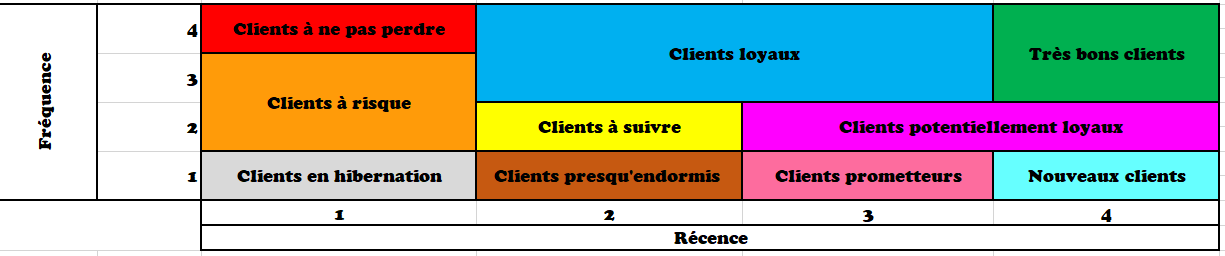

Il faut maintenant traduire cette carte en code python. 

In [20]:
#Définition de la carte de segmentation(voir le dessin ci-dessus) à travers un dictionnaire
segt_map = {
    r'11': 'Clients en hibernation',
    r'1[2-3]': 'Clients à risque',
    r'14': 'Clients à ne pas perdre',
    r'21': 'Clients presqu\'endormis',
    r'22': 'Clients à suivre',
    r'[2-3][3-4]': 'Clients loyaux',
    r'31': 'Clients prometteurs',
    r'41': 'Nouveaux clients',
    r'[3-4]2': 'Clients potentiellement loyaux',
    r'4[3-4]': 'Très bons clients'
}

#Ajout de la colonne "Segment" au dataframe rfm
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12346.0,326,2,0.00,1,2,1,121,Clients à risque
1,12347.0,2,7,4310.00,4,4,4,444,Très bons clients
2,12348.0,75,4,1797.24,2,3,4,234,Clients loyaux
3,12349.0,19,1,1757.55,3,1,4,314,Clients prometteurs
4,12350.0,310,1,334.40,1,1,2,112,Clients en hibernation


In [21]:
#Dictionnaire des codes de segmentations
code_segt = {
    'Très bons clients': 1,
    'Clients loyaux': 2,
    'Clients potentiellement loyaux': 3,
    'Clients prometteurs': 4,
    'Nouveaux clients': 5,
    'Clients à suivre': 6,
    'Clients à risque': 7,
    'Clients à ne pas perdre': 8,
    'Clients presqu\'endormis': 9,
    'Clients en hibernation': 10
}

#Ajout de la colonne "Code_segment" au dataframe rfm
rfm['Code_segment'] = rfm['Segment'].replace(code_segt)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Code_segment
0,12346.0,326,2,0.00,1,2,1,121,Clients à risque,7
1,12347.0,2,7,4310.00,4,4,4,444,Très bons clients,1
2,12348.0,75,4,1797.24,2,3,4,234,Clients loyaux,2
3,12349.0,19,1,1757.55,3,1,4,314,Clients prometteurs,4
4,12350.0,310,1,334.40,1,1,2,112,Clients en hibernation,10


On utilise le "Code_segment" pour faciliter la visualisation des segments grâce aux des différences de couleur dans notre nuage de points des récences en fonction des clients.

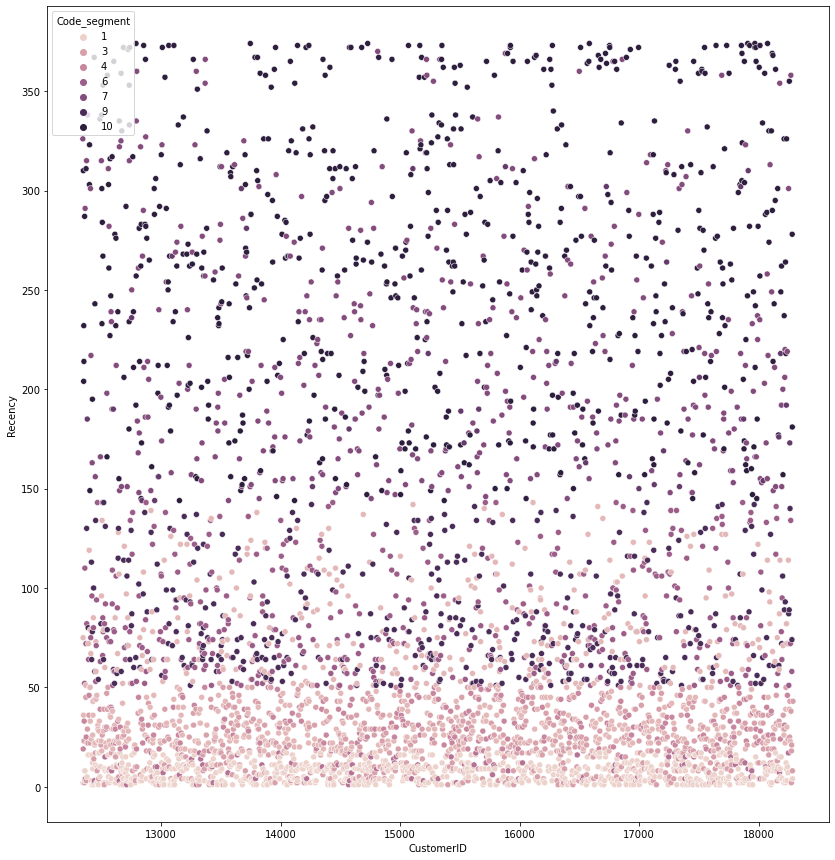

In [22]:
#Nuage de points des récences(Recency) en fonction des clients 
plt.figure(figsize=(14,15))
sns.scatterplot(data=rfm, x=rfm['CustomerID'], y=rfm['Recency'], hue='Code_segment')
plt.show()

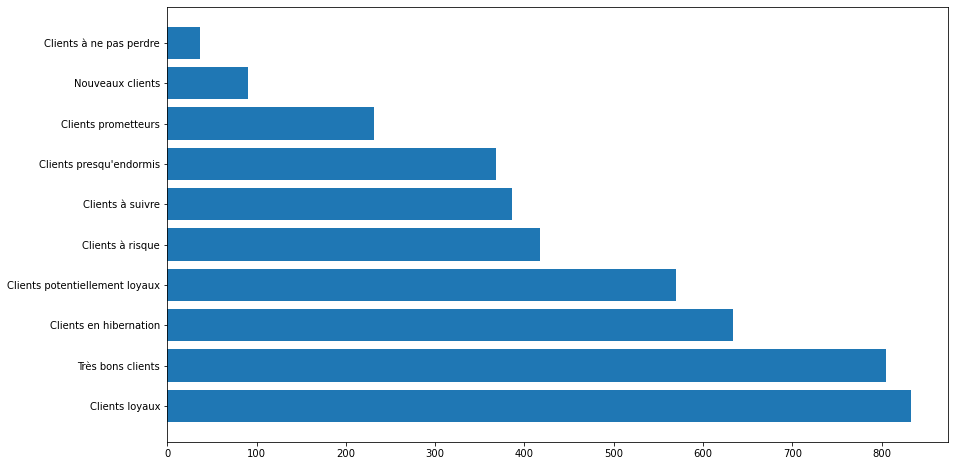

In [23]:
data = rfm['Segment'].value_counts().to_dict()
segments = list(data.keys())
values = list(data.values())

#Représentation des différents segments de clients
plt.figure(figsize=(14,8))
plt.barh(segments, values)
plt.show()

Le segment des "clients loyaux" est le plus représenté. Le moins représenté des segments est celui des "clients à ne pas perdre"

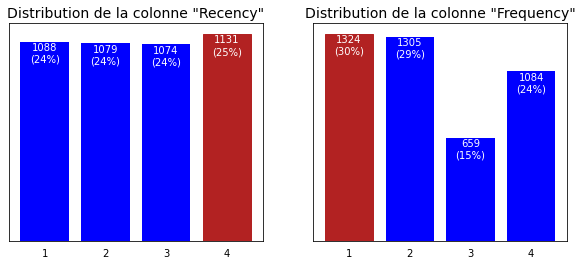

In [26]:
# Représentation des distributions des clients en fonction de Recency(R) et Frequency(F)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='blue')
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title(f'Distribution de la colonne "{parameters[p]}"',
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

Il y a 25% des clients qui ont effectué des achats récents (récence égale à 4).
<br>Il y a 30% des clients font très peu d'achats sur la période d'une année (fréquence égale à 1).

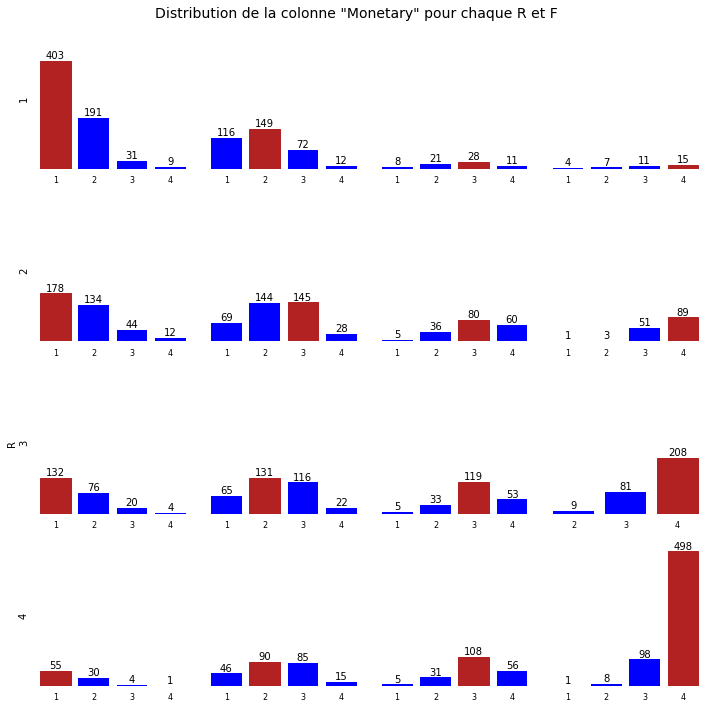

In [27]:
# Représentation de la distribution de la colonne Monetary (M) pour le RF_score(recency-frequency)
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 5)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='blue')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution de la colonne "Monetary" pour chaque R et F',
             fontsize=14)
plt.tight_layout()
plt.show()